# Uncalibrated photometric stereo constrained by intrinsic reﬂectance image and shape from silhoutte

In [ ]:
import cv2
import sys

import numpy as np

from pathlib import Path
from tenpy.linalg.svd_robust import svd
from RenderSurfaceMap import image_renderer

ModuleNotFoundError: No module named 'plotly'

In [ ]:
# read in the images from folder dataset/PhotometricStereo/PSData/cat/Objects
images = []

folder_path = Path("../Data/Dataset/")

for img_path in folder_path.glob('*.png'):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    images.append(img)

images = np.array(images)  # shape: (n_images, width, height)

In [ ]:
n_images,width, height = images.shape
print(n_images, width, height)

20 640 500


In [ ]:
# linearized_images = []
# for image in images:
#     linearized_image, _, _ = np.linalg.svd(image, compute_uv=True, full_matrices=False)
#     linearized_images.append(linearized_image)

# # convert to numpy array
# linearized_images = np.array(linearized_images)
# linearized_images[0].shape

## 3.2 Estimate of the Albedo

In [ ]:
# Calculate the average image
average_image = np.mean(images, axis=0)
# apply the bilateral filter to the average image
# parameters are the standard values from OpenCV: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed
albedo_estimate = cv2.bilateralFilter(average_image.astype(np.float32), d=9, sigmaColor=75, sigmaSpace=75)

In [ ]:
average_image.shape

(640, 500)

In [ ]:
albedo_estimate
# reshape to width x height
albedo_estimate = albedo_estimate.reshape((width, height, -1))

(-0.5, 499.5, 639.5, -0.5)

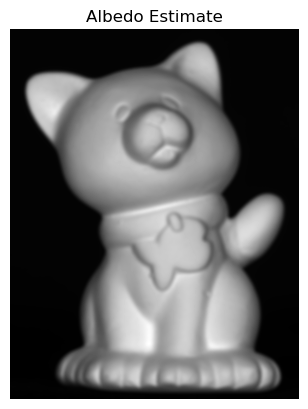

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(albedo_estimate, cmap='gray')
plt.title('Albedo Estimate')
plt.axis('off')

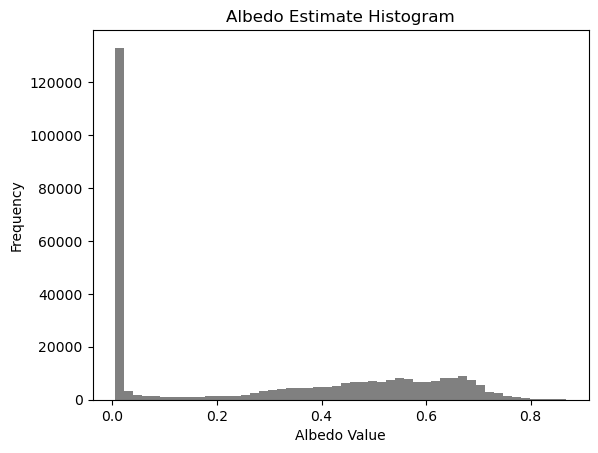

In [ ]:
# plot the albedo as a histogram
import matplotlib.pyplot as plt

plt.hist(albedo_estimate.ravel(), bins=50, color='gray')
plt.title('Albedo Estimate Histogram')
plt.xlabel('Albedo Value')
plt.ylabel('Frequency')
plt.show()

## 3.3 Singular value decomposition

In [ ]:
THRESHOLD = 0.1

# create mask for all pixels where albedo is above threshold
thresholded_albedo = albedo_estimate[:, :, 0] > THRESHOLD

# count number of pixels above threshold
P_tilde = np.count_nonzero(albedo_estimate >= THRESHOLD)
p_not_nan = P_tilde # TODO: change all p_not_nan to P_tilde
print('Number of non-thresholded pixels (P_tilde):', P_tilde)

# compute shading images
shading_images = []
for image in images:
    shading_image = np.zeros_like(image)
    shading_image[~thresholded_albedo] = np.nan # set values to nan where albedo is too low
    shading_image[thresholded_albedo] = image[thresholded_albedo] / albedo_estimate[:, :, 0][thresholded_albedo] # set shading values where albedo is high enough
    shading_images.append(shading_image)
shading_images = np.array(shading_images)  # shape: (n_images, width, height)
print('Shading images shape:', shading_images.shape)

# compute image matrix (I_tilde)
I_tilde = shading_images.transpose(1, 2, 0) # transpose shading images such that the images are the last dimension
I_tilde = I_tilde.reshape((width * height, n_images)) # reshape to 2D matrix (pixels x images)
I_tilde = I_tilde[thresholded_albedo.reshape(-1)] # filter to only include rows where albedo is above threshold
print('Image matrix shape (I_tilde):', I_tilde.shape)

Number of non-thresholded pixels (P_tilde): 178529
Shading images shape: (20, 640, 500)
Image matrix shape (I_tilde): (178529, 20)


In [ ]:
def svd_uwvt(A, k=3):
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    U_prime = U[:, :k]           # Shape: (P, 3)
    W_prime = np.diag(s[:k]) # Shape: (3, 3)
    Vt_prime = Vt[:k, :]         # Shape: (3, F)

    return U_prime, W_prime, Vt_prime

U_prime, W_prime, Vt_prime = svd_uwvt(I_tilde, k=3)

print(U_prime.shape, W_prime.shape, Vt_prime.shape)
# print(W)

(178529, 3) (3, 3) (3, 20)


In [ ]:
S_prime = U_prime
L_prime = np.dot(W_prime, Vt_prime)

## 3.4 Constant albedo constraint

In [ ]:
C = np.zeros((p_not_nan, 6))

# equation (15)
x = 0
y = 1
z = 2

for p in range(p_not_nan):
    n = S_prime[p, :]  # normal vector at pixel p
    C[p, 0] = n[x]**2
    C[p, 1] = n[y]**2
    C[p, 2] = n[z]**2
    C[p, 3] = 2 * n[x] * n[y]
    C[p, 4] = 2 * n[y] * n[z]
    C[p, 5] = 2 * n[z] * n[x]

C.shape

(178529, 6)

In [ ]:
ones_vector = np.ones((p_not_nan, 1))
pseudo_inverse = np.linalg.pinv(C) # C+ (C+ in equation (17) stands for pseudo-inverse)
b = np.dot(pseudo_inverse, ones_vector).T[0]
b

array([ 1.78311635e+05, -4.50790799e+02, -5.48863897e+02, -7.37808311e+02,
        6.91806572e+01, -9.17942762e+02])

In [ ]:
B = np.array([
    [b[0], b[3], b[5]],
    [b[3], b[1], b[4]],
    [b[5], b[4], b[2]]
]) 

In [ ]:
UB, WB, UtB = svd_uwvt(B, k=3)

A = np.dot(UB, np.sqrt(WB))

In [ ]:
S_2prime = np.dot(S_prime, A)
L_2prime = np.dot(np.linalg.inv(A), L_prime)

## 3.5 Constraint using guide normal

In [ ]:
def get_guide_normal(albedo_estimate, mask_threshold=0.1):
    # 1. Create a binary mask from your albedo estimate
    # (Pixels with sufficient albedo are part of the object)
    mask = (albedo_estimate > mask_threshold).astype(np.uint8)

    # 2. Use OpenCV to calculate the Distance Transform
    # This creates a 'height map' where the center of the object is 'high'
    # and the edges are 'low' (0).
    # DIST_L2 calculates the Euclidean distance.
    height_map = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

    # Normalize the height map to prevent extreme gradients
    if height_map.max() > 0:
        height_map = height_map / height_map.max() * (mask.shape[1] / 2)

    # 3. Calculate Gradients (Slope) of this height map
    # This tells us which way the 'surface' is tilting at each pixel
    # np.gradient computes the central difference
    dz_dy, dz_dx = np.gradient(height_map)

    # 4. Convert Slopes to Surface Normals
    # A surface normal is vector (-dz/dx, -dz/dy, 1)
    # We negate x and y because if the slope goes UP, the normal points BACK.
    guide_normal = np.dstack((-dz_dx, -dz_dy, np.ones_like(height_map)))

    # 5. Normalize the vectors to make them unit length
    norm = np.linalg.norm(guide_normal, axis=2, keepdims=True)
    guide_normal = np.divide(guide_normal, norm, where=norm!=0)

    # Mask out the background
    guide_normal[mask == 0] = 0

    return guide_normal

# Usage
S_tilde = get_guide_normal(average_image).reshape(-1, 3)[albedo_estimate.reshape(-1) >= THRESHOLD]

In [ ]:
R = np.dot(np.linalg.pinv(S_2prime), S_tilde) 
R_tilde, _= np.linalg.qr(R)

In [ ]:
S_temp = np.dot(S_2prime, R_tilde)
L = np.dot(R_tilde.T, L_2prime)

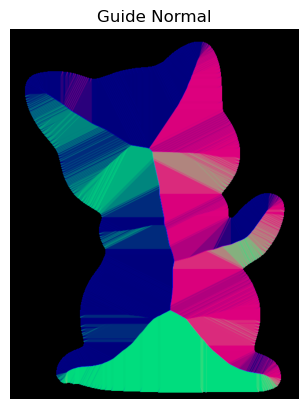

In [ ]:
# plot guide normal
plt.imshow(get_guide_normal(average_image).clip(0,1))
plt.title('Guide Normal')
plt.axis('off')
plt.show()

## Final output 

In [ ]:
num_pixels = width * height
I = np.zeros((num_pixels, n_images))

for image_idx in range(n_images):
    p_index = 0
    for i in range(width):
        for j in range(height):
            I[p_index, image_idx] = shading_images[image_idx, i, j]
            p_index += 1

In [ ]:
S = np.dot(I, np.linalg.pinv(L))

In [ ]:
# replace nan values with 0
S = np.nan_to_num(S, nan=0.0)
S_r = S.reshape((width, height, 3))

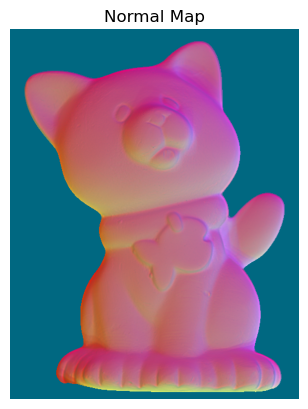

In [ ]:
# normalize S_r to get normal map
S_r_min = S_r.min(axis=(0,1), keepdims=True)
S_r_max = S_r.max(axis=(0,1), keepdims=True)
S_r_normalized = (S_r - S_r_min) / (S_r_max - S_r_min)

# reorder channels for visualization
S_r_normalized = S_r_normalized[:, :, [2, 1, 0]]  # from RGB to BGR

plt.imshow(S_r_normalized)
plt.title('Normal Map')
plt.axis('off')
plt.show()

In [ ]:
image_renderer(S_r, albedo_estimate)